In [1]:
kidney <- read.csv( "kidneytransplant.csv", header=TRUE )

head(kidney)

ptid,obstime,death,gender,race,age
1,1,0,1,1,46
2,5,0,1,1,51
3,7,1,1,1,55
4,9,0,1,1,57
5,13,0,1,1,45
6,13,0,1,1,43


In [2]:
## Recode gender and race to something meaningful
kidney$female <- kidney$gender - 1
kidney$black <- kidney$race - 1

In [6]:
## Compute overall KM estimate
library( survival )

kmEst.all <- survfit( Surv(obstime, death) ~ 1, data=kidney )
kmEst.all
summary(kmEst.all)


Attaching package: ‘survival’

The following object is masked _by_ ‘.GlobalEnv’:

    kidney



Call: survfit(formula = Surv(obstime, death) ~ 1, data = kidney)

      n  events  median 0.95LCL 0.95UCL 
    863     140      NA      NA      NA 

Call: survfit(formula = Surv(obstime, death) ~ 1, data = kidney)

 time n.risk n.event survival std.err lower 95% CI upper 95% CI
    2    861       1    0.999 0.00116        0.997        1.000
    3    860       1    0.998 0.00164        0.994        1.000
    7    857       2    0.995 0.00232        0.991        1.000
   10    853       2    0.993 0.00284        0.987        0.999
   17    848       1    0.992 0.00307        0.986        0.998
   21    844       1    0.991 0.00328        0.984        0.997
   26    843       2    0.988 0.00367        0.981        0.996
   28    840       1    0.987 0.00385        0.980        0.995
   37    836       1    0.986 0.00402        0.978        0.994
   40    835       1    0.985 0.00419        0.977        0.993
   43    834       2    0.982 0.00450        0.974        0.991
   44    829       1    0.981 0.00465        0.972        0.990
   45    828       1    0.980 0.00479        0.971        0.989
   50    826       1    0.979 0.00493 

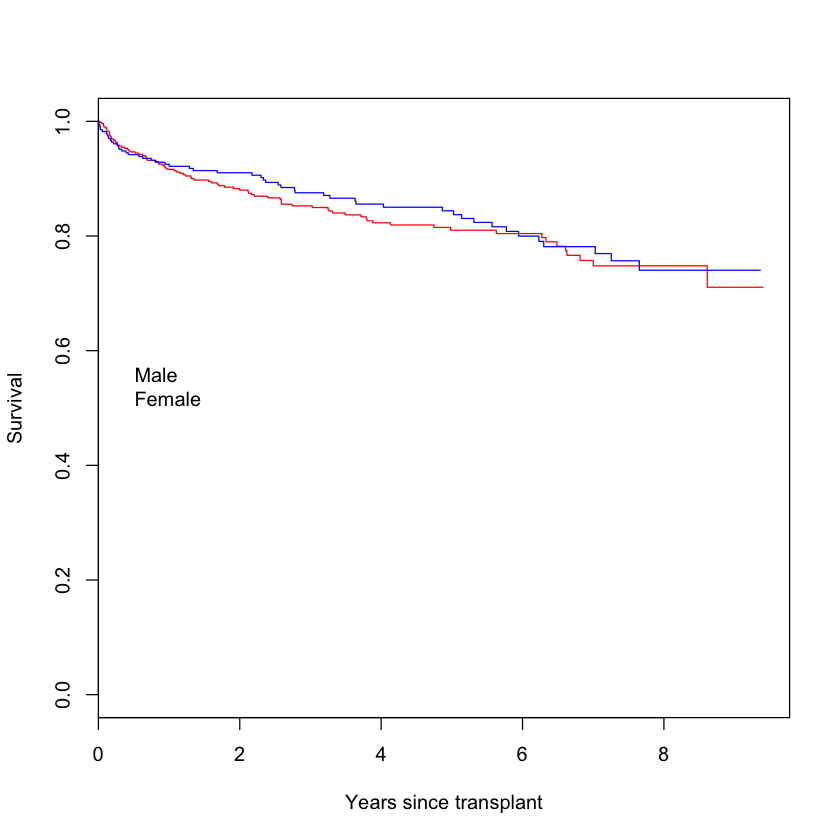

In [8]:
kmEst.gender <- survfit( Surv(obstime, death) ~ female, data=kidney )

plot( kmEst.gender, xscale=365.25, mark.time=FALSE, col = c('red', 'blue'),
ylab="Survival", xlab="Years since transplant" )

legend( 1, .6, col = c('red', 'blue'),legend=c("Male", "Female"), bty="n" )

In [9]:
pKM <- function( fit, q, xscale=1 ){
	fit$time <- fit$time / xscale
	if( is.null( fit$strata ) ) fit$strata <- length(fit$surv)
	nStrata <- length( fit$strata )
	rslt <- vector( "list", length=nStrata )
	names( rslt ) <- ifelse( nStrata==1, "Survival Probabilities", names( fit$strata ) )
	for( i in 1:nStrata ){
		rslt[[i]] <- as.data.frame( cbind( q, matrix(NA, nrow=length(q), ncol=3) ) )
		names( rslt[[i]] ) <- c( "time", "km.est", "lower", "upper" ) 
		strata.fit <-  as.data.frame( cbind( fit$time, fit$surv, fit$lower, fit$upper )[ (c(0,cumsum(fit$strata))[i]+1):(c(0,cumsum(fit$strata))[i]+fit$strata[i]), ] )
		names( strata.fit ) <- c("time", "surv", "lower", "upper" )
		for(j in 1:length(q)){
			if( sum(strata.fit$time > q[j]) > 1 ) rslt[[i]][j,2:4] <- strata.fit[ max( which(strata.fit$time <= q[j] ) ), 2:4 ]
			}
		}
	return(rslt)
	}
	
pKM(kmEst.gender, q=c(.5,1,2), xscale=365.25 )

time,km.est,lower,upper
0.5,0.9467434,0.9273872,0.9665036
1.0,0.9162635,0.8919893,0.9411982
2.0,0.8799810,0.8507622,0.9102033
time,km.est,lower,upper
0.5,0.9419531,0.9169427,0.9676457
1.0,0.9250765,0.8966287,0.9544268
2.0,0.9103050,0.8789995,0.9427255


In [11]:
##	Estimated 75th percentile of the survival distribution by gender
male.est <- as.data.frame( cbind( kmEst.gender$time, kmEst.gender$surv )[ 1:kmEst.gender$strata[1], ] )

female.est <- as.data.frame( cbind( kmEst.gender$time, kmEst.gender$surv )[ (kmEst.gender$strata[1]+1):sum(kmEst.gender$strata), ] )

names( male.est ) <- names( female.est ) <- c("time", "surv" )

In [12]:
male.est[ min( which(male.est$surv <=.75 ) ), ]
female.est[ min( which(female.est$surv <=.75 ) ), ]

,time,surv
347,2557,0.7479833


,time,surv
256,2795,0.7402676
